In [ ]:
import urllib
from IPython.display import Markdown as md
_nb_loc = "03_image_models/03a_transfer_learning.ipynb" # change to reflect your notebook
_nb_title = "5 Flowers Image Classification with Transfer Learning" # change to reflect your notebook
_nb_message = "In this notebook, we show how to build a neural network to classify the tf-flowers (5 flowers) dataset by using a pre-trained image embedding." # change to reflect your notebook
_icons=["https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/logo-cloud.png", "https://www.tensorflow.org/images/colab_logo_32px.png", "https://www.tensorflow.org/images/GitHub-Mark-32px.png", "https://www.tensorflow.org/images/download_logo_32px.png"]
_links=["https://console.cloud.google.com/ai-platform/notebooks/deploy-notebook?" + urllib.parse.urlencode({"name": _nb_title, "download_url": "https://github.com/GoogleCloudPlatform/practical-ml-vision-book/raw/master/"+_nb_loc}), "https://colab.research.google.com/github/GoogleCloudPlatform/practical-ml-vision-book/blob/master/{0}".format(_nb_loc), "https://github.com/GoogleCloudPlatform/practical-ml-vision-book/blob/master/{0}".format(_nb_loc), "https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/{0}".format(_nb_loc)]
md("""<table class="tfo-notebook-buttons" align="left"><td><a target="_blank" href="{0}"><img src="{4}"/>Run in AI Platform Notebook</a></td><td><a target="_blank" href="{1}"><img src="{5}" />Run in Google Colab</a></td><td><a target="_blank" href="{2}"><img src="{6}" />View source on GitHub</a></td><td><a href="{3}"><img src="{7}" />Download notebook</a></td></table><br/><br/><h1>{8}</h1>{9}""".format(_links[0], _links[1], _links[2], _links[3], _icons[0], _icons[1], _icons[2], _icons[3], _nb_title, _nb_message))

<table class="tfo-notebook-buttons" align="left"><td><a target="_blank" href="https://console.cloud.google.com/ai-platform/notebooks/deploy-notebook?name=5+Flowers+Image+Classification+with+Transfer+Learning&download_url=https%3A%2F%2Fgithub.com%2FGoogleCloudPlatform%2Fpractical-ml-vision-book%2Fraw%2Fmaster%2F03_image_models%2F03a_transfer_learning.ipynb"><img src="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/logo-cloud.png"/>Run in AI Platform Notebook</a></td><td><a target="_blank" href="https://colab.research.google.com/github/GoogleCloudPlatform/practical-ml-vision-book/blob/master/03_image_models/03a_transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a></td><td><a target="_blank" href="https://github.com/GoogleCloudPlatform/practical-ml-vision-book/blob/master/03_image_models/03a_transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a></td><td><a href="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/03_image_models/03a_transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a></td></table><br/><br/><h1>5 Flowers Image Classification with Transfer Learning</h1>In this notebook, we show how to build a neural network to classify the tf-flowers (5 flowers) dataset by using a pre-trained image embedding.

## Enable GPU and set up helper functions

This notebook and pretty much every other notebook in this repository
will run faster if you are using a GPU.
On Colab:
- Navigate to Edit→Notebook Settings
- Select GPU from the Hardware Accelerator drop-down

On Cloud AI Platform Notebooks:
- Navigate to https://console.cloud.google.com/ai-platform/notebooks
- Create an instance with a GPU or select your instance and add a GPU

Next, we'll confirm that we can connect to the GPU with tensorflow:

In [ ]:
import torch
print(torch.__version__)
device_name = torch.cuda.current_device()
print(f'GPU: {device_name}')

2.5.1+cu121
GPU: 0


In [ ]:
# Helper functions
import matplotlib
matplotlib.rcParams.update({'font.size': 15})
def training_plot(history):
    f, ax = plt.subplots(1, 2, figsize=(10,4))
    ax[0].plot(history['train_loss'])
    ax[0].plot(history['val_loss'], ls='dashed')
    ax[1].plot(history['train_accuracy'])
    ax[1].plot(history['val_accuracy'], ls='dashed')
    ax[0].set_xlabel("Epochs")
    ax[1].set_xlabel("Epochs")
    ax[0].legend(['train_loss', 'val_loss'], fontsize=15)
    ax[1].legend(['train_accuracy', 'val_accuracy'], fontsize=15)

# Call model.predict() on a few images in the evaluation dataset
device = "cuda:0"
s = torch.nn.Softmax(dim=1)
def plot_predictions(model, dataset):
    matplotlib.rcParams.update({'font.size': 14})
    f, ax = plt.subplots(3, 5, figsize=(25,15))
    for idx, (img, label) in enumerate(dataset):
        if idx > 14:
            break
        ax[idx//5, idx%5].imshow((img.transpose(1, 2, 0)));
        batch_img = torch.unsqueeze(torch.Tensor(img), 0)
        batch_img = batch_img.to(torch.float64).to(device)
        batch_img
        with torch.no_grad():
            ## forward + loss
            logits = model(batch_img)
            probs = s(logits)
            preds = torch.argmax(probs, dim=1)
        label = CLASS_NAMES[label]
        pred_label = CLASS_NAMES[preds[0]]
        ax[idx//5, idx%5].set_title('{} -> {} ({:.2f})'.format(label, pred_label, torch.max(probs)))
        ax[idx//5, idx%5].axis('off')

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("batoolabbas91/flower-photos-by-the-tensorflow-team")

print("Path to dataset files:", path)

100%|██████████| 219M/219M [00:11<00:00, 19.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/batoolabbas91/flower-photos-by-the-tensorflow-team/versions/1


In [ ]:
import matplotlib.pylab as plt
import numpy as np
import cv2
from glob import glob
import os

IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3

def read_img(filename, shape):
    img = cv2.imread(filename)
    img = img[..., ::-1]
    img = cv2.resize(img, shape)
    return img.astype(float) / 255

CLASS_NAMES = glob("/root/.cache/kagglehub/datasets/batoolabbas91/flower-photos-by-the-tensorflow-team/versions/1/flower_photos/*")
CLASS_NAMES = [os.path.basename(x) for x in CLASS_NAMES]
CLASS_NAMES = [x for x in CLASS_NAMES  if not '.' in x]
print("These are the available classes:", CLASS_NAMES)

These are the available classes: ['dandelion', 'sunflowers', 'roses', 'tulips', 'daisy']


## Fine-Tuning MobileNet

Let's load a pre-trained model and use it
instead of the Flattened layer as our first layer.

In [ ]:
# Set seed for reproducibility
np.random.seed(0)
torch.manual_seed(0);

In [ ]:
# split dataset to train / val
from sklearn.model_selection import train_test_split

data_dir = "/root/.cache/kagglehub/datasets/batoolabbas91/flower-photos-by-the-tensorflow-team/versions/1/"

X = glob(os.path.join(data_dir, "flower_photos/*/*.jpg"))
y = [filename.split('/')[-2] for filename in X]

X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                    stratify=y,
                                                    test_size=0.10)

import pandas as pd

# save splits
train_df = pd.DataFrame({"path": X_train, "flower": y_train})
val_df = pd.DataFrame({"path": X_val, "flower": y_val})

train_df.to_csv("flowers_train.csv", index=False)
val_df.to_csv("flowers_val.csv", index=False)

from torch.utils.data import Dataset
from torchvision.io import read_image

class FlowersDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = self.img_labels.iloc[idx, 0]
        image = read_img(img_path, [IMG_HEIGHT, IMG_WIDTH])
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image.transpose(2, 0, 1), label

train_dataset = FlowersDataset("flowers_train.csv", data_dir)
val_dataset = FlowersDataset("flowers_val.csv", data_dir)

# decode_csv changed so that the label is the index into CLASS_NAMES array
def idx_label(label):
  label = np.argmax(np.equal(CLASS_NAMES, label))
  return label

train_dataset.img_labels["flower"] = train_dataset.img_labels["flower"].map(idx_label)
val_dataset.img_labels["flower"] = val_dataset.img_labels["flower"].map(idx_label)

In [ ]:
## compute accuracy
def get_accuracy(inputs, target, batch_size):
    ''' Obtain accuracy for training round '''
    accuracy = torch.sum(inputs == target) / batch_size
    return accuracy.item()

In [ ]:
train_dataset[0][0].shape

(3, 224, 224)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision

class CustomModel(nn.Module):
    def __init__(self) -> None:
        super(CustomModel, self).__init__()
        self.mobilenet = torchvision.models.mobilenet_v2(weights='DEFAULT')
        self.pool = torch.nn.functional.adaptive_avg_pool2d

    def forward(self, x):
        x = self.mobilenet.features(x)
        x = self.pool(x, (1, 1))
        return torch.flatten(x, 1)

In [ ]:
from torchvision import transforms

preprocess = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

BATCH_SIZE = 32

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE,
                                          shuffle=False, num_workers=2)

In [ ]:
def train_loop(model,
               trainloader,
               valloader,
               criterion,
               optimizer,
            #    lr_scheduler,
            #    warmup_scheduler,
               num_epochs=10,
               batch_size=32,
               l1=0,
               l2=0
               ):
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_accuracy': [],
        'val_accuracy': [],
        'lr': []
    }

    model = model.to(dtype=torch.float64)

    for epoch in range(num_epochs):
        train_loss = 0.0
        train_accuracy = 0.0
        val_loss = 0.0
        val_accuracy = 0.0

        model = model.train()

        ## training step
        for i, (images, labels) in enumerate(trainloader):
            images = preprocess(images)
            images = images.to(device)
            labels = labels.to(device)

            ## forward + backprop + loss
            logits = model(images)
            loss = criterion(logits, labels)

            # Apply L1 regularization
            if l1 > 0:
                l1_norm = sum(p.abs().sum() for p in model.parameters())
                loss += l1 * l1_norm

            # Apply L2 regularization
            elif l2 > 0:
                l2_norm = sum(p.pow(2).sum() for p in model.parameters())
                loss += l2 * l2_norm

            optimizer.zero_grad()
            loss.backward()

            ## update model params
            optimizer.step()
            ## update lr
            # with warmup_scheduler.dampening():
            #     lr_scheduler.step()

            train_loss += loss.detach().item()

            probs = s(logits)
            inputs = torch.argmax(probs, dim=1)
            train_accuracy += get_accuracy(inputs, labels, batch_size)

        history['train_loss'].append(train_loss / len(trainloader))
        history['train_accuracy'].append(train_accuracy/len(trainloader))
        history['lr'].append(optimizer.param_groups[0]['lr'])
        print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' \
            %(epoch, train_loss / len(trainloader), train_accuracy / len(trainloader)))

        ## validation step
        model.eval()
        for i, (images, labels) in enumerate(valloader):

            images = preprocess(images)
            images = images.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                ## forward + loss
                logits = model(images)
                loss = criterion(logits, labels)

                val_loss += loss.detach().item()

                probs = s(logits)
                inputs = torch.argmax(probs, dim=1)
                val_accuracy += get_accuracy(inputs, labels, batch_size)

        history['val_loss'].append(val_loss / len(valloader))
        history['val_accuracy'].append(val_accuracy/len(valloader))

    return history

In [ ]:
! pip install pytorch_warmup

In [ ]:
# import pytorch_warmup as warmup

def train_and_evaluate(trainloader,
                       valloader,
                       num_epochs=10,
                       batch_size = 8,
                       lr_start = 1e-3, # default in Adam constructor
                       l1 = 0,
                       l2 = 0,
                       num_hidden = 16
                       ):

    model = torch.nn.Sequential(
        CustomModel(),
        torch.nn.Linear(in_features=1280,
                        out_features=num_hidden),
        torch.nn.ReLU(),
        torch.nn.Linear(in_features=num_hidden, out_features=5)
    )
    model = model.to(device)

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr_start, eps=1e-4)
    # warmup_scheduler = warmup.ExponentialWarmup(optimizer, warmup_period=600)
    # lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,
    #                                                         T_max=int(len(trainloader)*num_epochs))

    history = train_loop(model, trainloader, valloader, criterion, optimizer, num_epochs, l1=l1, l2=l2)
    training_plot(history)
    return model, history

## No scheduler

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 44.0MB/s]


Epoch: 0 | Loss: 0.5532 | Train Accuracy: 0.80
Epoch: 1 | Loss: 0.2905 | Train Accuracy: 0.90
Epoch: 2 | Loss: 0.1984 | Train Accuracy: 0.93
Epoch: 3 | Loss: 0.1610 | Train Accuracy: 0.94
Epoch: 4 | Loss: 0.1336 | Train Accuracy: 0.95
Epoch: 5 | Loss: 0.0889 | Train Accuracy: 0.97
Epoch: 6 | Loss: 0.0761 | Train Accuracy: 0.97
Epoch: 7 | Loss: 0.1205 | Train Accuracy: 0.96
Epoch: 8 | Loss: 0.0797 | Train Accuracy: 0.97
Epoch: 9 | Loss: 0.0666 | Train Accuracy: 0.97


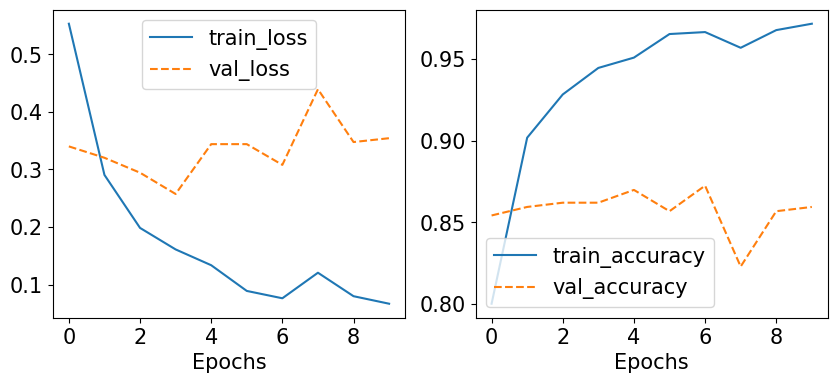

In [ ]:
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE,
                                          shuffle=False, num_workers=2)

model, history = train_and_evaluate(trainloader, valloader)

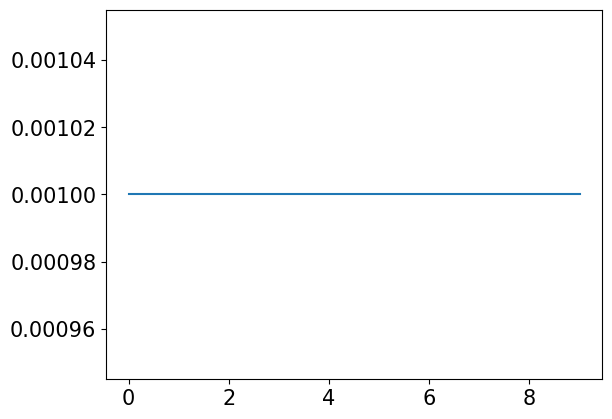

In [ ]:
plt.plot(history['lr'])

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 151MB/s]


Epoch: 0 | Loss: 1.5911 | Train Accuracy: 0.23
Epoch: 1 | Loss: 1.5051 | Train Accuracy: 0.35
Epoch: 2 | Loss: 1.3756 | Train Accuracy: 0.46
Epoch: 3 | Loss: 1.2176 | Train Accuracy: 0.62


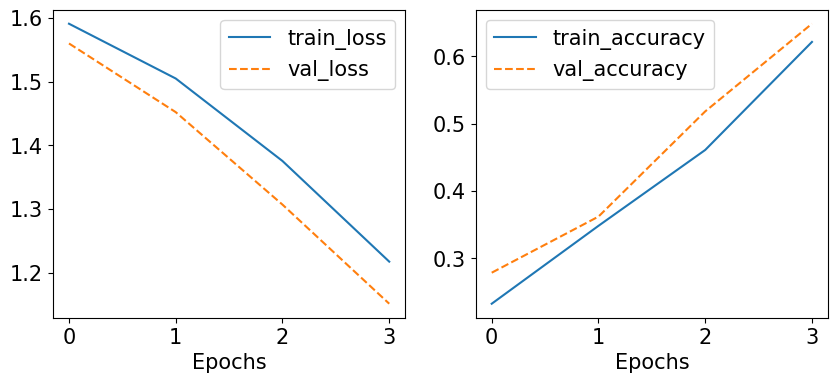

In [ ]:
model, history = train_and_evaluate(trainloader, valloader, num_epochs=4, lr_start=1e-5)

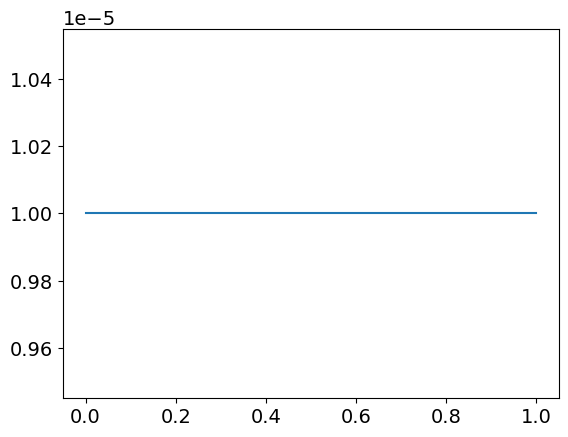

In [ ]:
plt.plot(history['lr'])